# Practice Notebook for checking things working

##### This notebook is to play around with the pipeline and the changes will be made in the other files for this pipeline

### Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import warnings
from qiskit import QuantumCircuit, Aer, execute
from qiskit.visualization import plot_histogram
from qiskit.circuit import Parameter
import torch 
import numpy as np
from pyscf import gto, scf
import scipy.sparse as sp
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigsh,eigs
import scipy.linalg as la
import scipy.sparse as sp


warnings.filterwarnings('ignore')

# Hamiltonian Matrix Construction

In [2]:
# Define the molecule
mol = gto.M(atom=[
    ['O', (0.0, 0.0, 0.0)],          # Oxygen at origin
    ['H', (0.0, -0.757, 0.587)],     # Hydrogen 1
    ['H', (0.0, 0.757, 0.587)]       # Hydrogen 2
], basis='6-311G')

# Perform Hartree-Fock Calculation
mf = scf.RHF(mol)
mf.kernel()

# Obtain Molecular Orbitals Coefficients and Integrals
mo_coeff = mf.mo_coeff
h1 = mf.get_hcore(mol)
g2 = mol.intor('int2e', aosym='s1')

# Transform Two-Electron Integrals to MO Basis
g2_mo = np.einsum('pqrs,pi,qj,rk,sl->ijkl', g2, mo_coeff, mo_coeff, mo_coeff, mo_coeff)

# Number of orbitals and occupied orbitals
num_orbitals = mo_coeff.shape[1]
nocc = mol.nelectron // 2  # Assuming a closed-shell molecule

# Compute the Density Matrix
P = 2 * np.dot(mo_coeff[:, :nocc], mo_coeff[:, :nocc].T)

# Construct the Fock Matrix
F = np.copy(h1)
for i in range(num_orbitals):
    for j in range(num_orbitals):
        for k in range(num_orbitals):
            for l in range(num_orbitals):
                F[i, j] += P[k, l] * (2 * g2_mo[i, j, k, l] - g2_mo[i, k, j, l])

# Expand the Fock Matrix to include spin orbitals
num_spin_orbitals = 2 * num_orbitals
F_spin = np.zeros((num_spin_orbitals, num_spin_orbitals))
for i in range(num_orbitals):
    for j in range(num_orbitals):
        F_spin[i, j] = F[i, j]
        F_spin[i + num_orbitals, j + num_orbitals] = F[i, j]

# Convert the Fock Matrix to a sparse matrix


# Step 8: Scale Up to a Larger Sparse Matrix
# The Hamiltonian matrix is converted into a sparse matrix format.
H_spin_sparse = sp.csr_matrix(F_spin)

# A much larger sparse matrix (`large_H_spin_sparse`) is created.
size = 2**14
large_H_spin_sparse = sp.lil_matrix((size, size))
# Convert H_spin to a sparse matrix
H_spin_sparse = sp.csr_matrix(F_spin)

size = 2**14

num_repetitions = size // F_spin.shape[0]

# Create a list of H_spin matrices
H_spin_blocks = [F_spin] * num_repetitions

# Create the block diagonal matrix
large_H_spin_block = la.block_diag(*H_spin_blocks)

# Convert to a sparse matrix
large_H_spin_sparse_csr = sp.csr_matrix(large_H_spin_block)


converged SCF energy = -76.00933224033


#### See the true lowest eigenvalue

In [3]:
large_H_spin_sparse_csr

<16378x16378 sparse matrix of type '<class 'numpy.float64'>'
	with 311182 stored elements in Compressed Sparse Row format>

In [4]:

# Assuming large_H_spin_sparse_csr is your large sparse Hamiltonian matrix
# Find the smallest eigenvalue
# 'which='SA'' means to find the smallest algebraic eigenvalue
eigenvalues, eigenvectors = eigsh(large_H_spin_sparse_csr, k=1, which='SA')

# Extract the smallest eigenvalue
smallest_eigenvalue = eigenvalues[0]
print("Smallest eigenvalue:", smallest_eigenvalue)


Smallest eigenvalue: -63.73326475196804


#### Check the size of the matrix

In [5]:
large_H_spin_sparse_csr.shape

(16378, 16378)

# Hybrid Quantum-Classical Autoencoder Model + Training Loop

### Classical Encoder

In [14]:
# Define the classical encoder neural network
class ClassicalEncoder(nn.Module):
    def __init__(self):
        super(ClassicalEncoder, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(16378, 28),  # First layer with 7 inputs and 14 outputs
            nn.ReLU(),         # Activation function
            #nn.Linear(28, 56), # Second layer with 14 inputs and 28 outputs
            #nn.ReLU(),         # Activation function
            #nn.Linear(56, 28), # Third layer with 28 inputs and 56 outputs
            #nn.ReLU(),         # Activation function
            #nn.Linear(28, 14), # Fourth layer reducing from 56 to 28 outputs
            #nn.ReLU(),         # Activation function
            nn.Linear(28, 4) # Fifth layer reducing from 28 to 14 outputs
        )
    
    def forward(self, x):
        return self.fc(x)

encoder = ClassicalEncoder()
#print("The encoder is: ", encoder)

### Parameterized Quantum Cirucit

In [15]:
# Define a function to execute the quantum circuit
def run_quantum_circuit(params):
    # Create a list of parameters for the quantum circuit
    theta = [Parameter(f'θ{i}') for i in range(4)]

    # add control rotation gates
    
    # Create a quantum circuit with 4 qubits and 4 classical bits
    qc = QuantumCircuit(4)
    
    # Apply initial Ry and Rx rotations
    for i in range(4):
        qc.ry(theta[i], i)
        qc.rx(theta[i], i)

    qc.cnot(3,0)
    qc.cnot(1,0)
    qc.cnot(2,1)
    qc.cnot(3,2)

    qc.barrier()

    for i in range(4):
        qc.rx(theta[i], i)
        qc.ry(theta[i], i)
        qc.rx(theta[i], i)

    qc.cnot(3,0)
    qc.cnot(1,0)
    qc.cnot(2,1)
    qc.cnot(3,2)

    qc.barrier()

    for i in range(4):
        qc.rx(theta[i], i)
        qc.ry(theta[i], i)
        qc.rx(theta[i], i)

    qc.cnot(3,0)
    qc.cnot(1,0)
    qc.cnot(2,1)
    qc.cnot(3,2)

    qc.barrier()
    
    

    # Add measurements to all qubits
    qc.measure_all()
    
    # Bind the parameters to the values from the PyTorch model
    param_dict = {theta[i]: params[i].item() for i in range(4)}
    qc_bound = qc.bind_parameters(param_dict)
    
    # Print the quantum circuit
    #print(qc_bound)

    # If you want a visual diagram of the circuit, you can use:
    # circuit_drawer(qc_bound, output='mpl').show()

    # Execute the quantum circuit
    backend = Aer.get_backend('qasm_simulator')
    job = execute(qc_bound, backend, shots=1024)
    result = job.result()
    counts = result.get_counts(qc_bound)
    
    # Plot the histogram of results
    plot_histogram(counts)
    
    # Get the most common bitstring
    output_bitstring = max(counts, key=counts.get)
    
    # Convert bitstring to numpy array of integers
    output_data = np.array([int(bit) for bit in output_bitstring])
    
    # Convert to PyTorch tensor
    output_tensor = torch.tensor(output_data, dtype=torch.float32)
    
    return output_tensor

### Classical Decoder

In [16]:
# Define the classical decoder neural network
class ClassicalDecoder(nn.Module):
    def __init__(self):
        super(ClassicalDecoder, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(4, 28),    # First layer with 4 inputs and 8 outputs
            #nn.ReLU(),          # Activation function
            #nn.Linear(8, 16),   # Second layer with 8 inputs and 16 outputs
            #nn.ReLU(),          # Activation function
            #nn.Linear(16, 32),  # Third layer with 16 inputs and 32 outputs
            #nn.ReLU(),          # Activation function
            #nn.Linear(32, 64),
            #nn.ReLU(),
            #nn.Linear(64, 32),  # Fourth layer reducing from 32 to 16 outputs
            nn.ReLU(),          # Activation function
            nn.Linear(28, 16378)
        )
    
    def forward(self, x):
        return self.fc(x)

decoder = ClassicalDecoder()
#print("The decoder is: ", decoder)

### Building the Hybrid Model for Learning

In [22]:
class HybridModel(nn.Module):
    def __init__(self):
        super(HybridModel, self).__init__()
        self.encoder = ClassicalEncoder()
        self.decoder = ClassicalDecoder()
        self.qcircuit = run_quantum_circuit

    def forward(self, x):
        encoded = self.encoder(x)
        #quantum_result = self.qcircuit(encoded)
        decoded = self.decoder(encoded)
        return decoded

# Initialize the model
model = HybridModel()

### Expectation Value Calculation

In [18]:
# Define the loss function (energy expectation)
def energy_expectation(output, hamiltonian):
    # Your implementation here using PyTorch operations
    # Define the molecule

    # Convert Hamiltonian matrix to complex tensor

    # Extract the row indices, column indices, and values from the CSR matrix
    rows, cols = hamiltonian.nonzero()
    values = hamiltonian.data

    # Convert to torch tensors
    rows = torch.tensor(rows, dtype=torch.int64)
    cols = torch.tensor(cols, dtype=torch.int64)
    values = torch.tensor(values, dtype=torch.cfloat)

    # Create indices tensor for the sparse tensor
    indices = torch.vstack((rows, cols))

    # Create the PyTorch sparse tensor
    H_complex = torch.sparse_coo_tensor(indices, values, size=large_H_spin_sparse_csr.shape)

    # Convert to dense tensor and then take the real part
    H_complex_dense = H_complex.to_dense()
    H_complex_real_dense = H_complex_dense.real

    # Assuming values is the tensor of complex values
    real_values = values.real  # Extract the real part before creating the sparse tensor

    # Create the sparse tensor with real values
    H_complex_real = torch.sparse_coo_tensor(indices, real_values, size=large_H_spin_sparse_csr.shape)



    # Convert to real part only if needed
    #H_complex = H_complex.real()
    #H_complex = torch.tensor(hamiltonian, dtype=torch.cfloat).real

    wavefunction = output  # Assuming this is a complex tensor
    #wavefunction_np = wavefunction.detach().numpy()
    #expectation_value = np.dot(wavefunction_np, np.dot(hamiltonian, wavefunction_np))

    # Normalize the wavefunction
    norm_wavefunction = wavefunction / torch.sqrt(torch.sum(torch.abs(wavefunction)**2))

    # Check if the size of the Hamiltonian matches the size of the wavefunction
    # This is crucial, and you need to address this if there's a mismatch
    assert H_complex.shape[0] == norm_wavefunction.shape[0], "Size mismatch between Hamiltonian and wavefunction"

    # Calculate the energy expectation value
    energy = torch.vdot(norm_wavefunction, torch.mv(H_complex_real, norm_wavefunction)).real


    return energy #torch.tensor([0.0], requires_grad=True)  # Example placeholder

### Training Loop

In [23]:
# Sample input
input_data = torch.rand(16378, requires_grad=True)  # Example input
#input_data= torch.tensor([ 0.3679, -0.0602,  0.6200,  0.1083, -0.0054,  0.0107,  0.1241, 0.3679, -0.0602,  0.6200,  0.1083, -0.0054,  0.0107,  0.1241])

# Optimization setup
#print("The model parameters are: ", model.parameters)
optimizer = optim.Adam(model.parameters(), lr=0.01)
num_epochs = 100
loss_values = []

for epoch in range(num_epochs):
    optimizer.zero_grad()            # Clear existing gradients
    output = model(input_data)       # Forward pass

    # Ensure output requires grad
    if not output.requires_grad:
        raise RuntimeError("Output does not require gradients. Check model implementation.")

    # Calculate the loss
    #initial_hamiltonian = hamiltonian_initial_module.mf.get_hcore()
    #final_hamiltonian = hamiltonian_final_module.mf.get_hcore()
    loss = energy_expectation(output,large_H_spin_sparse_csr)
    # Check if loss requires grad
    if not loss.requires_grad:
        raise RuntimeError("Loss does not require gradients. Check energy_expectation implementation.")

    loss.backward()                  # Backward pass
    optimizer.step()                 # Update parameters
    loss_values.append(loss.item())  # Store loss for plotting
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")


Epoch 1/100, Loss: -2.6989970207214355
Epoch 2/100, Loss: -5.456280708312988
Epoch 3/100, Loss: -11.094783782958984
Epoch 4/100, Loss: -17.416542053222656
Epoch 5/100, Loss: -24.074987411499023
Epoch 6/100, Loss: -30.543180465698242
Epoch 7/100, Loss: -36.83278274536133
Epoch 8/100, Loss: -42.49440383911133
Epoch 9/100, Loss: -47.597904205322266
Epoch 10/100, Loss: -51.873043060302734
Epoch 11/100, Loss: -55.099945068359375
Epoch 12/100, Loss: -57.45328903198242
Epoch 13/100, Loss: -58.98179626464844
Epoch 14/100, Loss: -59.897422790527344
Epoch 15/100, Loss: -60.452796936035156
Epoch 16/100, Loss: -60.80939865112305
Epoch 17/100, Loss: -61.05200958251953
Epoch 18/100, Loss: -61.2479248046875
Epoch 19/100, Loss: -61.441619873046875
Epoch 20/100, Loss: -61.64301300048828
Epoch 21/100, Loss: -61.845298767089844
Epoch 22/100, Loss: -62.04412841796875
Epoch 23/100, Loss: -62.23872375488281
Epoch 24/100, Loss: -62.42523193359375
Epoch 25/100, Loss: -62.59686279296875
Epoch 26/100, Loss: -62

### Training Loss Plot

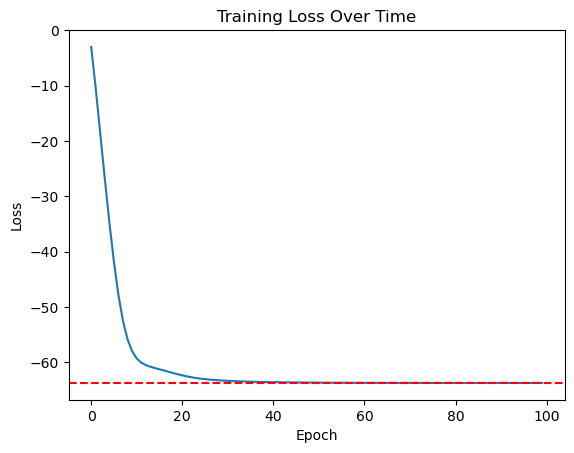

In [20]:
# Plotting the loss values
plt.plot(loss_values)
plt.axhline(y=smallest_eigenvalue, color='r', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.show()

#### Energy difference

In [25]:
def diff_calculator(true,network_energy):
    value = abs(true- network_energy)
    return value


print("Energy difference in percentage : ", diff_calculator(smallest_eigenvalue, loss_values[99]))

Energy difference in percentage :  0.00041181617702790163


In [27]:
# second one
def diff_calculator(true,network_energy):
    value = abs(true- network_energy)/ abs(true)
    return value


print("Energy difference in percentage : ", diff_calculator(smallest_eigenvalue, loss_values[99]))

Energy difference in percentage :  6.461557847861309e-06
